In [20]:
from datasets.mnist import read_data
import numpy as np
from utils import *

FIG_FOLDER = 'mnist'
SAVE_PLOTS = True # save all the plots

# load the data
chose_split = False # load all the data and then chose how to split
if chose_split:
    X, y = read_data.load_all_data()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1337)
    del X # save some space
    del y # save some space
else:
    # load the training and testing sets as given by the author
    x_train, y_train = read_data.load_train_data()
    x_test, y_test = read_data.load_test_data()

# serialize images (from 2d to 1d)
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

test = True # for testing stuff without the need to wait an eternity
# test = False # for testing stuff without the need to wait an eternity
if test:
    x_train = x_train[:4000]
    y_train = y_train[:4000]
    x_test = x_test[:500]
    y_test = y_test[:500]

In [21]:
# subsample training data in order to equalize class frequencies
# we match the lowest class frequency
vals, freq = np.unique(y_train, return_counts = True)
wanted_freq = min(freq)
all_indexes = np.zeros((len(freq), wanted_freq), dtype=np.uint32)
for i, v in enumerate(vals):
    indexes = np.random.choice(np.where(y_train == v)[0], size=wanted_freq, replace=False)
    all_indexes[i, :] = indexes
all_indexes = np.sort(all_indexes.flatten())
y_train = y_train[all_indexes]
x_train = x_train[all_indexes, :]

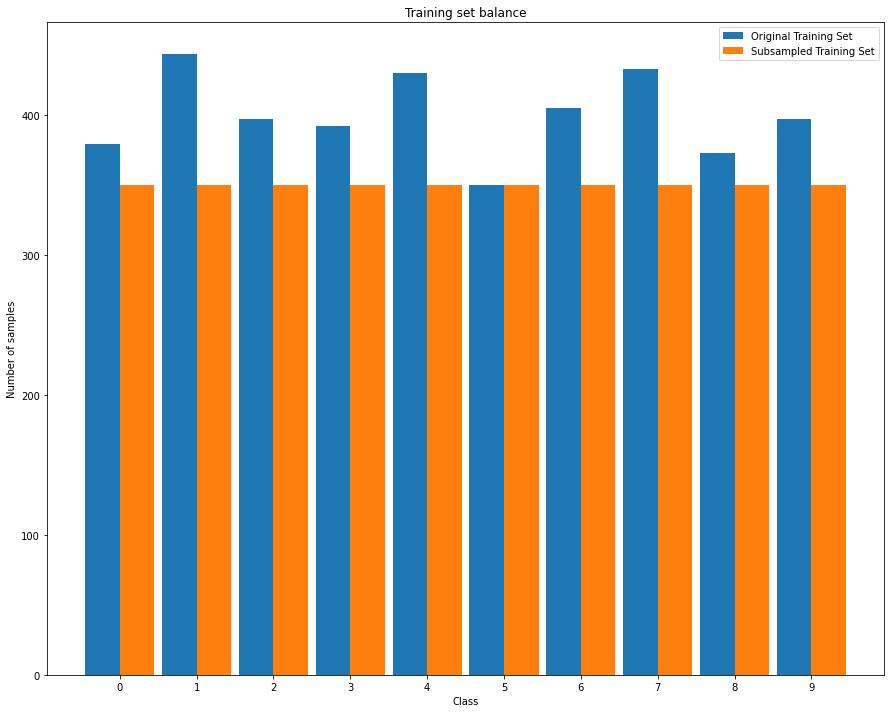

In [22]:
import matplotlib.pyplot as plt

vals2, freq2 = np.unique(y_train, return_counts = True)
x_ = np.arange(len(freq))
width = 0.45

fig, ax = plt.subplots(figsize=(15,12))
ax.bar(x_ - width/2, freq, width, label='Original Training Set')
plt.bar(x_ + width/2, freq2, width, label='Subsampled Training Set')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Class')
ax.set_title('Training set balance')
ax.set_xticks(x_)
ax.set_xticklabels(vals)
ax.legend()
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'training_freq', FIG_FOLDER)

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([('scaler1', MinMaxScaler()),
                 ('PCA', PCA(0.9)),
                 ('scaler2', MinMaxScaler()),
                ])
pipe.fit(x_train)
x_train = pipe.transform(x_train)
x_test = pipe.transform(x_test)

In [24]:
params = [
          {'kernel': ('linear',), 'C': (0.1, 1, 10)},
          {'kernel': ('poly',), 'C': (0.1, 1, 10), 'degree': (2, 3, 4), 'gamma': (0.1, 1, 10)},
          {'kernel': ('rbf',), 'C': (1, 10, 50), 'gamma': (0.01, 0.1, 1, 10, 100)},
          {'kernel': ('sigmoid',), 'C': (10, 100, 1000, 10000), 'gamma': (0.0001, 0.001, 0.01, 0.1)},
         ]

models = []
for kwargs in params:
    models.append(GS_wrapper(SVC(decision_function_shape='ovo'), kwargs, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1))

In [25]:
# Fit the models
for model in models:
    t0 = time()
    model.fit(x_train, y_train)
    mins, secs = divmod(time() - t0, 60)
    print(f'{mins} mins {secs:.4f} secs')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.0 mins 3.5080 secs
Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.0 mins 15.8344 secs
Fitting 3 folds for each of 15 candidates, totalling 45 fits
0.0 mins 29.0140 secs
Fitting 3 folds for each of 16 candidates, totalling 48 fits
0.0 mins 19.5807 secs


In [26]:
# print best parameters for every model and the score
for model in models:
    print(model.best_params_, model.best_score_)

{'C': 1, 'kernel': 'linear'} 0.8975341856373619
{'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'} 0.9088980048906582
{'C': 10, 'gamma': 1, 'kernel': 'rbf'} 0.9339424811314253
{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'} 0.8987304946326432


In [27]:
# calculate the metrics
for model in models:
    model.calculate_train_test_metrics(x_train, y_train, x_test, y_test)
    # print(model.train_metrics, model.test_metrics)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
t0 = time()
knn.fit(x_train, y_train)
knn_time = time() - t0

knn_train_metrics = calculate_metrics(knn, x_train, y_train)
knn_test_metrics = calculate_metrics(knn, x_test, y_test)

In [29]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()
t0 = time()
nc.fit(x_train, y_train)
nc_time = time() - t0
nc_train_metrics = calculate_metrics(nc, x_train, y_train)
nc_test_metrics = calculate_metrics(nc, x_test, y_test)

In [30]:
# create data for the plots
names = []
times = []
acc = [[], []]
prec = [[], []]
recall = [[], []]
f1 = [[], []]
for model in models:
    if hasattr(model, 'refit_time_'):
        times.append(model.refit_time_)
    else:
        times.append(model.train_time)

    acc[0].append(model.train_metrics[0]) 
    acc[1].append(model.test_metrics[0]) 
    prec[0].append(model.train_metrics[1]) 
    prec[1].append(model.test_metrics[1]) 
    recall[0].append(model.train_metrics[2]) 
    recall[1].append(model.test_metrics[2]) 
    f1[0].append(model.train_metrics[3]) 
    f1[1].append(model.test_metrics[3]) 

    if hasattr(model, 'best_params_'):
        names.append("\n".join([f'{key}: {val}' for key, val in model.best_params_.items()]))
    else:
        if model.init_kwargs is not None:
            if hasattr(model, 'kernel'):
                names.append(f'{model.kernel}, ' + ", ".join([f'{key}: {val}' for key, val in model.init_kwargs.items()]))
            else:
                names.append(", ".join([f'{key}: {val}' for key, val in model.init_kwargs.items()]))
        else:
            names.append(f'{model.kernel}')

# add kNN and nearest class centroid
names.append('kNN: 3 neighbors\nweighted (L2)')
names.append('Nearest Centroid')
times.append(knn_time)
times.append(nc_time)
acc[0].append(knn_train_metrics[0]) 
acc[1].append(knn_test_metrics[0]) 
acc[0].append(nc_train_metrics[0]) 
acc[1].append(nc_test_metrics[0]) 

prec[0].append(knn_train_metrics[1]) 
prec[1].append(knn_test_metrics[1]) 
prec[0].append(nc_train_metrics[1]) 
prec[1].append(nc_test_metrics[1]) 

recall[0].append(knn_train_metrics[2]) 
recall[1].append(knn_test_metrics[2]) 
recall[0].append(nc_train_metrics[2]) 
recall[1].append(nc_test_metrics[2]) 

f1[0].append(knn_train_metrics[3]) 
f1[1].append(knn_test_metrics[3]) 
f1[0].append(nc_train_metrics[3]) 
f1[1].append(nc_test_metrics[3]) 

In [ ]:
import matplotlib.pyplot as plt

# plot times
fig = plt.figure(figsize=(15,12))
ax = plt.bar(names, times)
plt.title('Training time')
plt.xlabel('Model')
plt.ylabel('Time in seconds')
plt.xticks(rotation=45)
plt.show()

if SAVE_PLOTS:
    save_plots(fig, 'training_time', FIG_FOLDER)

In [ ]:
# plot accuracy
fig, ax = plt.subplots(figsize=(15,12))

x_ = np.arange(len(names))
width = 0.35

ax.bar(x_ - width/2, acc[0], width, label='Train')
ax.bar(x_ + width/2, acc[1], width, label='Test')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.set_xticks(x_)
ax.set_xticklabels(names)
ax.legend()
plt.xticks(rotation=45)
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'accuracy', FIG_FOLDER)

In [ ]:
# plot precision
fig, ax = plt.subplots(figsize=(15,12))

x_ = np.arange(len(names))
width = 0.35

ax.bar(x_ - width/2, prec[0], width, label='Train')
ax.bar(x_ + width/2, prec[1], width, label='Test')

ax.set_ylabel('Precision')
ax.set_title('Precision')
ax.set_xticks(x_)
ax.set_xticklabels(names)
ax.legend()
plt.xticks(rotation=45)
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'precision', FIG_FOLDER)

In [ ]:
# plot recall
fig, ax = plt.subplots(figsize=(15,12))

x_ = np.arange(len(names))
width = 0.35

ax.bar(x_ - width/2, recall[0], width, label='Train')
ax.bar(x_ + width/2, recall[1], width, label='Test')

ax.set_ylabel('Recall')
ax.set_title('Recall')
ax.set_xticks(x_)
ax.set_xticklabels(names)
ax.legend()
plt.xticks(rotation=45)
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'recall', FIG_FOLDER)

In [ ]:
# plot f1
fig, ax = plt.subplots(figsize=(15,12))

x_ = np.arange(len(names))
width = 0.35

ax.bar(x_ - width/2, f1[0], width, label='Train')
ax.bar(x_ + width/2, f1[1], width, label='Test')

ax.set_ylabel('F1 score')
ax.set_title('F1 score')
ax.set_xticks(x_)
ax.set_xticklabels(names)
ax.legend()
plt.xticks(rotation=45)
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'f1', FIG_FOLDER)

In [ ]:
# plot all metrics
fig, ax = plt.subplots(2, 1, figsize=(19,12))

plt.subplots_adjust(hspace=.3)

x_ = np.arange(len(names))
width = 0.8

div = 4
ax[0].bar(x_ - width/2 + 0*width/4, acc[0], width/4, label='Accuracy')
ax[0].bar(x_ - width/2 + 1*width/4, prec[0], width/4, label='Precision')
ax[0].bar(x_ - width/2 + 2*width/4, recall[0], width/4, label='Recall')
ax[0].bar(x_ - width/2 + 3*width/4, f1[0], width/4, label='F1')

ax[0].set_title('Metrics during training')
ax[0].set_xticks(x_)
ax[0].set_xticklabels(names, rotation=45)
ax[0].legend()

ax[1].bar(x_ - width/2 + 0*width/4, acc[1], width/4, label='Accuracy')
ax[1].bar(x_ - width/2 + 1*width/4, prec[1], width/4, label='Precision')
ax[1].bar(x_ - width/2 + 2*width/4, recall[1], width/4, label='Recall')
ax[1].bar(x_ - width/2 + 3*width/4, f1[1], width/4, label='F1')

ax[1].set_title('Metrics during test')
ax[1].set_xticks(x_)
ax[1].set_xticklabels(names, rotation=45)
ax[1].legend()

plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'all_metrics', FIG_FOLDER)

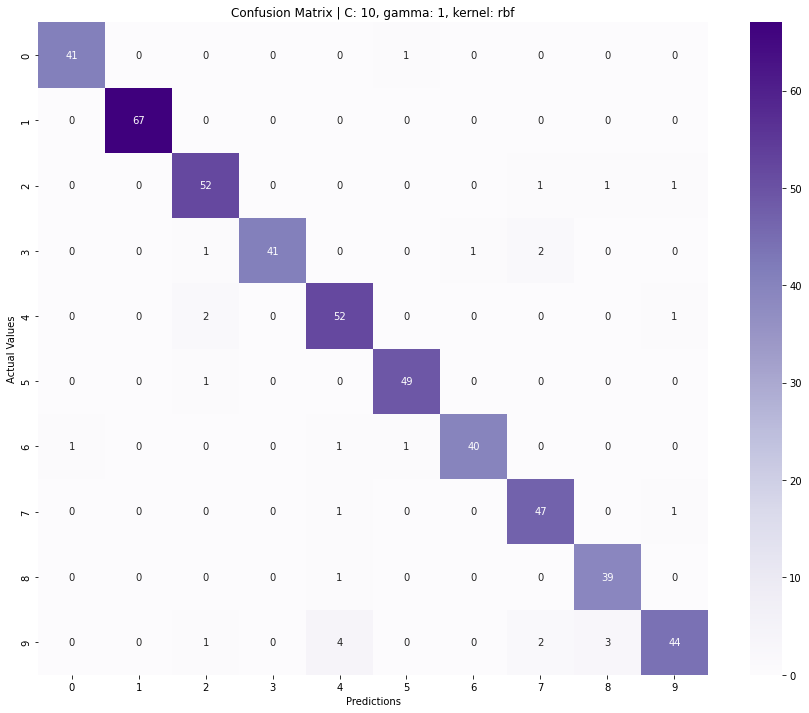

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# pick the best model (based in test f1 score)
best = max(models, key=lambda x: x.test_metrics[3])
best_name =", ".join([f'{key}: {val}' for key, val in best.best_params_.items()])
pred = best.predict(x_test)

fig = plt.figure(figsize=(15,12))
ax = sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Purples', fmt='g')

ax.set_title(f'Confusion Matrix | {best_name}')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(list(range(10)))
ax.yaxis.set_ticklabels(list(range(10)))

plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'confusion_matrix', FIG_FOLDER)

In [34]:
import pandas as pd

save_folder = f'results/{FIG_FOLDER}/'
create_if_not_exists(save_folder)

# save training data
data = zip(names, acc[0], prec[0], recall[0], f1[0], times)
col_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "Training Time (seconds)"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'training_data.xlsx', float_format="%.4f", index=False)

# save test data
data = zip(names, acc[1], prec[1], recall[1], f1[1])
col_names = ["Model", "Accuracy", "Precision", "Recall", "F1"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'test_data.xlsx', float_format="%.4f", index=False)

[0 2 3 4 5 6 7 8 9]
[16  5  1  4  0  7  2 12  3]
[0 2 3 4 5 6 7 8 9]
[5 9 2 9 2 5 9 4 4]
(9, 28, 28)
0
254


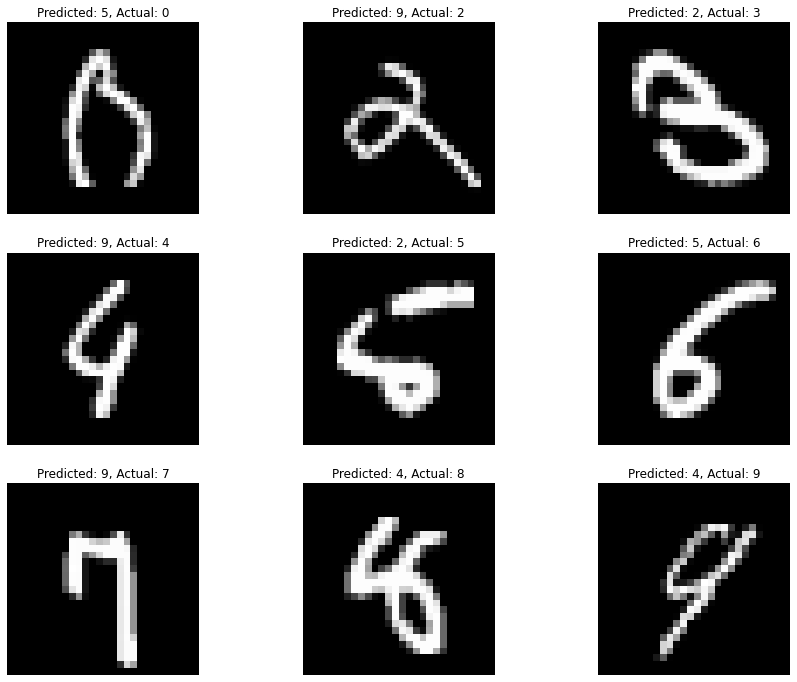

IndexError: index 2 is out of bounds for axis 0 with size 2

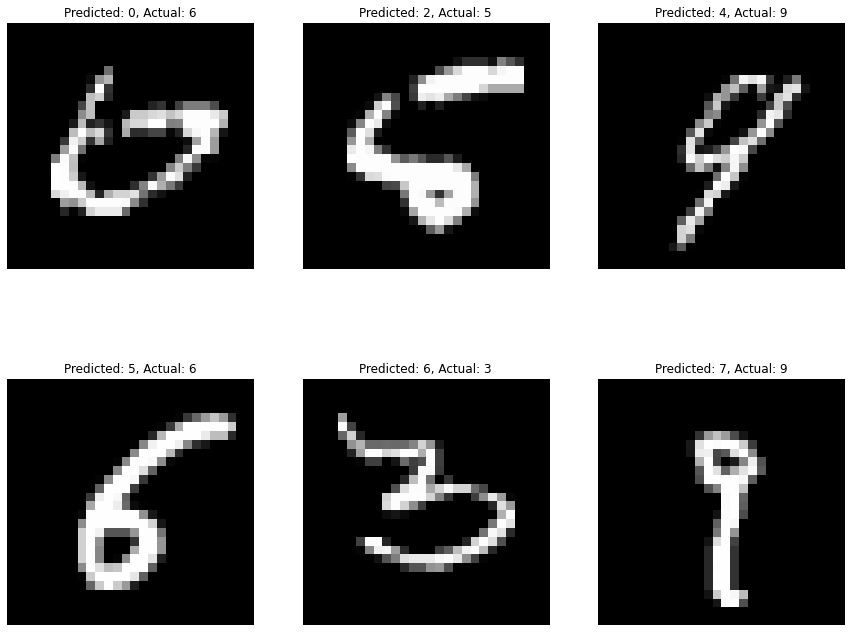

In [74]:
# print wrong classifications
wrong_classifications = np.where((pred ^ y_test) != 0)[0]
wrong_classes, wrong_idxs = np.unique(y_test[wrong_classifications], return_index=True)

x_test, _ = read_data.load_test_data()

# wrong_images = pipe.inverse_transform(x_test[wrong_classifications[wrong_idxs], :]).reshape(-1,28,28)
wrong_images = x_test[wrong_classifications[wrong_idxs], :]

print(np.min(wrong_images[0]))
print(np.max(wrong_images[0]))

if len(wrong_idxs) == 9:
    nrows, ncols = 3, 3
elif len(wrong_idxs) == 10:
    nrows, ncols = 5, 2
else:
    nrows, ncols = len(wrong_idxs) // 3, 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15,12))
for i, image in enumerate(wrong_images):
    ax[i//ncols, i%ncols].imshow(image, cmap='gray', vmin=0, vmax=255)
    ax[i//ncols, i%ncols].axis('off')
    ax[i//ncols, i%ncols].set_title(f'Predicted: {pred[wrong_classifications[wrong_idxs[i]]]}, Actual: {y_test[wrong_classifications[wrong_idxs[i]]]}')
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'wrong_results_1', FIG_FOLDER)

wrong_classes, wrong_idxs = np.unique(pred[wrong_classifications], return_index=True)
wrong_images = x_test[wrong_classifications[wrong_idxs], :]

if len(wrong_idxs) == 9:
    nrows, ncols = 3, 3
elif len(wrong_idxs) == 10:
    nrows, ncols = 5, 2
else:
    nrows, ncols = len(wrong_idxs) // 3, 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(15,12))
for i, image in enumerate(wrong_images):
    ax[i//ncols, i%ncols].imshow(image, cmap='gray', vmin=0, vmax=255)
    ax[i//ncols, i%ncols].axis('off')
    ax[i//ncols, i%ncols].set_title(f'Predicted: {pred[wrong_classifications[wrong_idxs[i]]]}, Actual: {y_test[wrong_classifications[wrong_idxs[i]]]}')
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'wrong_results_2', FIG_FOLDER)